In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/580Project/continuous"

Mounted at /content/drive
/content/drive/My Drive/580Project/continuous


In [ ]:
! pip3 install qpsolvers[open_source_solvers]
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.9/959.9 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import qpsolvers
from qpsolvers import solve_qp
from scipy.optimize import linprog
import cvxopt as cvx
from sklearn.metrics import r2_score as r2_score_np
from torcheval.metrics.functional import r2_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from scipy.stats import norm
import pickle

In [ ]:
df = pd.read_csv("../data/student/student-mat.csv", sep=';')

In [ ]:
df_encoded = pd.get_dummies(df, columns=["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian",
                                         "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"], drop_first=True)
df_encoded.drop(["G1", "G2"], inplace=True, axis=1)

In [ ]:
features = df_encoded.drop(["G3"], axis=1)
target = df_encoded["G3"]
X = torch.tensor(features.values, dtype=torch.float)
X = X - X.mean(dim=0)
X = X/X.std(dim=0)
Y = torch.tensor(target.values, dtype=torch.float)
Y = Y - Y.mean()

In [ ]:
m = X.shape[1]
n = X.shape[0]
k = 10
l = 40

In [ ]:
def project_onto_simplex(v, select, total, solver="cvxopt"):
    P = 2*np.eye(total)
    q = -2*v.astype(np.double)
    A = np.ones((1, total))
    b = np.array([select]).astype(np.double)
    lb = np.zeros(total)
    ub = np.ones(total)
    proj = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, solver=solver)
    return proj

def frank_wolfe(gradV, select, total):
    c = gradV
    A_eq = np.ones((1, total))
    b_eq = np.array([select])
    bounds = (0, 1)
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    return res.x

In [ ]:
class ContSolve(torch.nn.Module):
    def __init__(self, X, Y, k, l, device):
        super(ContSolve, self).__init__()
        self.X = X.to(torch.device(device))
        self.Y = Y.to(torch.device(device))
        for tensor in [self.X, self.Y]:
            tensor.requires_grad = False
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
        self.device = torch.device(device)
        self.ps = torch.nn.Parameter(torch.full((self.m,), self.k/self.m).to(self.device), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.full((self.n,), self.l/self.n).to(self.device), requires_grad=True)

    def forward(self):
        scaled_X = torch.einsum('n,nm->nm',self.qs,self.X)
        scaled_X = torch.einsum('nm,m->nm',scaled_X,self.ps)
        scaled_Y = torch.einsum('n,n->n',self.Y,self.qs)
        tilde_M = torch.einsum('mn,np->mp',scaled_X.T,scaled_X)
        tilde_M_inv = torch.linalg.inv(tilde_M)
        tilde_M_inv_Xt = torch.einsum('mn,np->mp',tilde_M_inv,scaled_X.T)
        beta = torch.einsum('mn,n->m',tilde_M_inv_Xt,scaled_Y)
        resid = scaled_Y - torch.einsum('nm,m->n',scaled_X,beta)
        r2 = 1 - torch.einsum('n,n->',resid,resid)/torch.einsum('n,n->',scaled_Y,scaled_Y)
        return r2

In [ ]:
device = "cuda"
cs = ContSolve(X, Y, k, l, device)
learning_rate = 10
for epoch in range(1, 51):
    r2 = cs()
    print(r2)
    loss = r2
    loss.backward()
    with torch.no_grad():
        cs.qs -= learning_rate * cs.qs.grad
        cs.ps += learning_rate * cs.ps.grad
    proj = project_onto_simplex(cs.qs.detach().cpu().numpy(), l, n)
    cs.qs.data = torch.Tensor(proj).to(device)
    proj2 = project_onto_simplex(cs.ps.detach().cpu().numpy(), k, m)
    cs.ps.data = torch.Tensor(proj2).to(device)
    cs.qs.grad.zero_()
    cs.ps.grad.zero_()

In [ ]:
cs = ContSolve(X, Y, k, l, device)
cs.qs.requires_grad = True
cs.ps.requires_grad = True
for epoch in range(1, 51):
    t_k = 2/(epoch+2)
    r2 = cs()
    print(r2)
    loss = r2
    loss.backward()
    with torch.no_grad():
        y = frank_wolfe(cs.qs.grad.detach().cpu().numpy(), l, n)
        cs.qs.data = (1-t_k) * cs.qs.data + t_k * torch.Tensor(y).to(device)
        cs.qs.grad.zero_()
        y2 = frank_wolfe(-cs.ps.grad.detach().cpu().numpy(), k, m)
        cs.ps.data = (1-t_k) * cs.ps.data + t_k * torch.Tensor(y2).to(device)
        cs.ps.grad.zero_()

In [ ]:
def sample_bernoulli(k, p):
    n = len(p)
    sample = np.zeros(n, dtype=int)
    remaining_probabilities = p.numpy().copy()

    for _ in range(k):
        normalized_probabilities = remaining_probabilities / sum(remaining_probabilities)
        selected_index = np.random.choice(n, p=normalized_probabilities)
        sample[selected_index] = 1
        remaining_probabilities[selected_index] = 0

    return sample

In [ ]:
class ContSolve2(torch.nn.Module):
    def __init__(self, X, Y, k, l, device, samples):
        super(ContSolve2, self).__init__()
        self.X = X.to(torch.device(device))
        self.Y = Y.to(torch.device(device))
        for tensor in [self.X, self.Y]:
            tensor.requires_grad = False
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
        self.device = torch.device(device)
        self.ps = torch.nn.Parameter(torch.full((self.m,), self.k/self.m).to(self.device), requires_grad=False)
        self.qs = torch.nn.Parameter(torch.full((self.n,), self.l/self.n).to(self.device), requires_grad=False)
        self.samples = samples

    def forward(self):
        m_include = torch.zeros((self.samples, self.m), dtype=torch.bool)
        n_include = torch.zeros((self.samples, self.n), dtype=torch.bool)
        res = torch.zeros(self.samples)

        for i in range(self.samples):
            m_include[i] = torch.Tensor(sample_bernoulli(self.k, self.ps))
            n_include[i] = torch.Tensor(sample_bernoulli(self.l, self.qs))
#             torch.bernoulli(self.ps, out=m_include[i])
#             torch.bernoulli(self.qs, out=n_include[i])
            if torch.sum(m_include[i]) == 0 or torch.sum(n_include[i]) == 0:
                res[i] = 0
                continue
            curr_X = self.X[n_include[i]][:, m_include[i]]
            curr_Y = self.Y[n_include[i]]
            beta = torch.linalg.lstsq(curr_X, curr_Y).solution
            pred = torch.einsum('nm,m->n',curr_X,beta)
            r2 = r2_score(pred, curr_Y)
            res[i] = 1 - (1 - r2)*torch.sum(n_include[i])/(
                torch.sum(n_include[i]) - torch.sum(m_include[i]) - 1)

        m_include = m_include.type(torch.float)
        m_sum = torch.einsum('km->m',m_include)
        m_update = torch.zeros(self.m)
        m_valid = (m_sum > 0) & (m_sum < self.samples)
        m_pos_res = torch.einsum('k,km->m',res,m_include[:,m_valid])/m_sum[m_valid]
        m_neg_res = (torch.sum(res) - m_pos_res)/(self.samples - m_sum)[m_valid]
        m_update[m_valid] = m_pos_res - m_neg_res

        n_include = n_include.type(torch.float)
        n_sum = torch.einsum('kn->n',n_include)
        n_update = torch.zeros(self.n)
        n_valid = (n_sum > 0) & (n_sum < self.samples)
        n_pos_res = torch.einsum('k,km->m',res,n_include[:,n_valid])/n_sum[n_valid]
        n_neg_res = (torch.sum(res) - n_pos_res)/(self.samples - n_sum)[n_valid]
        n_update[n_valid] = n_pos_res - n_neg_res

        return res, m_update, n_update

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.12, 0.25, 0.5]
device = "cpu"
samples = 50
allqs = []
allps = []
for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        print(l/n)
        print(k/m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []
        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break
            learning_rate = 1/np.sqrt(epoch)
            q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            cs.qs.data -= learning_rate * n_update.to(device) / torch.tensor(1 - q_prob).to(device)
            proj = project_onto_simplex(cs.qs.cpu().numpy(), l, n)
            cs.qs.data = torch.clamp(torch.Tensor(proj).to(device), min=1e-6, max=1-1e-6)
            p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            cs.ps.data += learning_rate * m_update.to(device) / torch.tensor(1 - p_prob).to(device)
            proj2 = project_onto_simplex(cs.ps.cpu().numpy(), k, m)
            cs.ps.data = torch.clamp(torch.Tensor(proj2).to(device), min=1e-6, max=1-1e-6)
            epoch += 1
        allqs.append(totalq)
        allps.append(totalp)

0.05822784810126582
0.05128205128205128
0.1189873417721519
0.05128205128205128
0.2481012658227848
0.05128205128205128
0.49873417721518987
0.05128205128205128
0.05822784810126582
0.10256410256410256
0.1189873417721519
0.10256410256410256
0.2481012658227848
0.10256410256410256
0.49873417721518987
0.10256410256410256
0.05822784810126582
0.23076923076923078
0.1189873417721519
0.23076923076923078
0.2481012658227848
0.23076923076923078
0.49873417721518987
0.23076923076923078
0.05822784810126582
0.48717948717948717
0.1189873417721519
0.48717948717948717
0.2481012658227848
0.48717948717948717
0.49873417721518987
0.48717948717948717


In [ ]:
with open('simplex_qs2.pkl', 'wb') as f:
    pickle.dump(allqs, f)
with open('simplex_ps2.pkl', 'wb') as f:
    pickle.dump(allps, f)

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.12, 0.25, 0.5]
device = "cpu"
samples = 50
allqs2 = []
allps2 = []
for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        print(l/n)
        print(k/m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []
        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break
            learning_rate = 1/np.sqrt(epoch)
            q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            cs.qs.data -= learning_rate * n_update.to(device) / torch.tensor(1 - q_prob).to(device)
            proj = project_onto_simplex(cs.qs.cpu().numpy(), l, n)
            cs.qs.data = torch.clamp(torch.Tensor(proj).to(device), min=1e-6, max=1-1e-6)
            p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            cs.ps.data += learning_rate * m_update.to(device) / torch.tensor(1 - p_prob).to(device)
            proj2 = project_onto_simplex(cs.ps.cpu().numpy(), k, m)
            cs.ps.data = torch.clamp(torch.Tensor(proj2).to(device), min=1e-6, max=1-1e-6)
            epoch += 1
        allqs2.append(totalq)
        allps2.append(totalp)

In [ ]:
with open('simplex_qs.pkl', 'wb') as f:
    pickle.dump(allqs, f)
with open('simplex_ps.pkl', 'wb') as f:
    pickle.dump(allps, f)

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.1, 0.25, 0.5]
device = "cuda"
samples = 50
allqs2 = []
allps2 = []

for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []

        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break

            t_k = 1/np.sqrt(epoch)
            # q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            # t_q_k = t_k / torch.tensor(1 - q_prob).to(device)
            # p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            # t_p_k = t_k / torch.tensor(1 - p_prob).to(device)

            y = frank_wolfe(n_update.cpu().numpy(), l, n)
            cs.qs.data = (1-t_k) * cs.qs.data + t_k * torch.Tensor(y).to(device)
            y2 = frank_wolfe(-m_update.cpu().numpy(), k, m)
            cs.ps.data = (1-t_k) * cs.ps.data + t_k * torch.Tensor(y2).to(device)
            epoch += 1

        allqs2.append(prevq)
        allps2.append(prevp)

In [ ]:
with open('frank_wolfe_qs.pkl', 'wb') as f:
    pickle.dump(allqs2, f)
with open('frank_wolfe_ps.pkl', 'wb') as f:
    pickle.dump(allps2, f)

In [ ]:
with open('simplex_qs.pkl', 'rb') as f:
    allqs = pickle.load(f)
with open('simplex_ps.pkl', 'rb') as f:
    allps = pickle.load(f)

In [ ]:
def find_best_mod(x, y, ps, qs, k, l, verify=1, num_samples=100):

    # TODO: handle mixed probabilities better

    largest_col_indices = np.argsort(-ps)[:k]
    largest_row_indices = np.argsort(-qs)[:l]
    final_x = x[largest_row_indices][:, largest_col_indices].numpy()
    final_y = y[largest_row_indices].numpy()
    reg = LinearRegression().fit(final_x, final_y)
    pred = reg.predict(final_x)
    final_r2 = r2_score_np(final_y, pred)

    if verify == 1:
        best_r2 = 1
        largest_indices = np.argsort(-ps)[:k]
        curr_x = x[:, largest_indices]
        for i in range(num_samples):
            random_indices = np.random.choice(qs.size, size=l, replace=False)
            temp_x = curr_x[random_indices]
            temp_y = y[random_indices]
            reg = LinearRegression().fit(temp_x, temp_y)
            pred = reg.predict(temp_x)
            r2 = r2_score_np(temp_y, pred)
            if best_r2 > r2:
                best_r2 = r2
        return final_r2 - best_r2

    elif verify == 2:
        best_r2 = 0
        largest_indices = np.argsort(-qs)[:l]
        curr_x = x[largest_indices, :]
        curr_y = y[largest_indices]
        for i in range(num_samples):
            random_indices = np.random.choice(ps.size, size=k, replace=False)
            temp_x = curr_x[:, random_indices]
            reg = LinearRegression().fit(temp_x, curr_y)
            pred = reg.predict(temp_x)
            r2 = r2_score_np(curr_y, pred)
            if best_r2 < r2:
                best_r2 = r2
        return best_r2 - final_r2


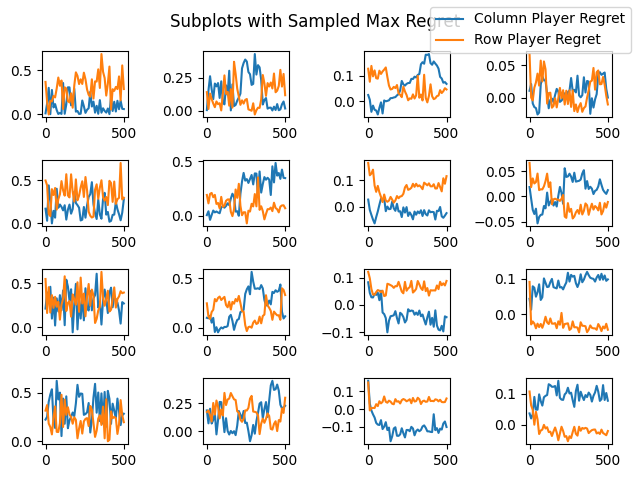

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.suptitle("Subplots with Sampled Max Regret")

checks = 50
for i in range(len(allps)):
    allp = allps[i]
    allq = allqs[i]
    k = round(np.sum(allp[-1]))
    l = round(np.sum(allq[-1]))
    row_devs = []
    col_devs = []

    for j in np.linspace(0, len(allp)-1, checks):
        currps = allp[int(j)]
        currqs = allq[int(j)]
        row_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=1)
        col_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=2)
        row_devs.append(row_dev)
        col_devs.append(col_dev)
    # currps = allp[-1]
    # currqs = allq[-1]
    # row_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=1)
    # col_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=2)
    # row_devs.append(row_dev)
    # col_devs.append(col_dev)

    x = np.linspace(0, len(allp)-1, checks)
    axes[i//4, i%4].plot(x, row_devs, label = "Column Player Regret")
    axes[i//4, i%4].plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

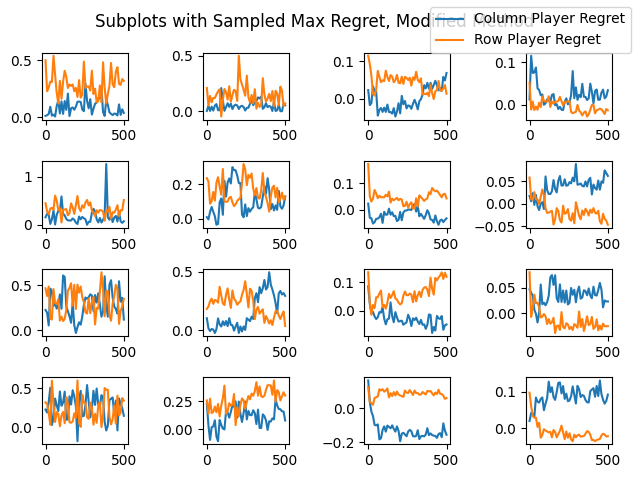

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.suptitle("Subplots with Sampled Max Regret, Modified Method")

checks = 50
for i in range(len(allps)):
    allp = allps[i]
    allq = allqs[i]
    k = round(np.sum(allp[-1]))
    l = round(np.sum(allq[-1]))
    row_devs = []
    col_devs = []

    for j in np.linspace(0, len(allp)-1, checks):
        currps = allp[int(j)]
        currqs = allq[int(j)]
        row_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=1)
        col_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=2)
        row_devs.append(row_dev)
        col_devs.append(col_dev)

    x = np.linspace(0, len(allp)-1, checks)
    axes[i//4, i%4].plot(x, row_devs, label = "Column Player Regret")
    axes[i//4, i%4].plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()